## Demonstrating functions for Taylor scale project

This notebook demonstrates the construction of the final dataset for the Taylor scale project. Each row of the dataset is a 6-hour period of the solar wind as measured by the Wind spacecraft, and each column is a quantity or parameter of the solar wind for this period. The two parameters we are most interested are the *correlation scale* and *Taylor scale*. Both scales are calculated from the autocorrelation function, and both require some thought as to what technique to use to calculate them.

Previously, **Kevin de Lange** created an equivalent dataset and investigated the correlation between the Taylor scale and the other variables, including training machine learning models to predict the Taylor scale. *He found an unexpected, reasonably strong positive correlation between the Taylor scale and correlation scale*. Specifically, he found a correlation of 0.77 between the Taylor scale and exponential-fit correlation scale, and 0.62 between the Taylor scale and the 1/e-trick correlation scale.                                                                 

We are now more rigorously estimating the Taylor scale to confirm or deny this correlation. ~90% of the work to construct this updated dataset is completed, but this needs to be checked and some points clarified. These are indicated in **<u>bold underline</u>** throughout the notebook.

### Notes
- Scales are returned in units of seconds
- For demonstration purposes, `plot=True` arguments in functions assume a solar wind speed of 400km/s. The specific speeds measured for each interval are used in the actual analysis. 

### To-do
Aftering going through the notebook and clarifying the method:
1. Implement changes as suggested by Tulasi

- Choose Taylor scale fit range based on linear range, cf. previous work.
- Choose exp fit range based on 1/e method, cf. previous work
- Add error bars for Taylor scale estimates, à la Phillips et al (and others). Use numpy or scipy fit method. *Std of points? Try lm() in R*
- Tidy notebook, ensuring decisions are described

2. Put into functions in .py script/s, and test pipeline on two months of data (Jan-Feb 2016), using importlib.reload
2. From this, reconstruct Fig. 5.1 from Kevin's report
2. Check with Tulasi
2. Run pipeline on full five (+?) years of data
3. Plot normalised time series of the scales
4. Compute correlation matrix and potentially cross-correlation of the scales

In [163]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm
import astropy.units as u
from astropy.table import Table

while ".toplevel" not in os.listdir():
    os.chdir("..")

from utils import pipeline, print_cdf_info, join_dataframes_on_timestamp, read_cdf

#### Reading in Omni data

6-hour averages, first processed and saved to `.pkl` file by `process_data_omni.py`

In [164]:
df_omni = pd.read_pickle("data/processed/omni_6hr.pkl")
df_omni.columns = df_omni.columns.str.lower()
df_omni = df_omni.rename(
    columns={
        'proton_density':'proton_density_omni',
        't':'temperature',
        'beta':'plasma_beta',  
        'e':'electric_field',  
        'pressure':'flow_pressure'})
df_omni.describe()

,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,7.629370,88446.203125,415.195892,1.876287,2.352355,0.788729
std,5.309639,79275.312500,84.458252,1.285798,1.254984,0.686382
min,1.501792,10210.652344,268.823608,0.062431,0.421444,0.076406
25%,4.092863,36289.657227,353.235924,1.120479,1.582026,0.368339
50%,6.067542,67387.437500,396.871201,1.559008,2.029808,0.579917
75%,9.312843,113806.886719,464.271729,2.189879,2.754799,0.924743
max,32.507652,647744.625000,629.847229,10.137687,8.122097,5.598134


Demonstrating use of Units features from `astropy` package (not currently used)

In [165]:
# Can also use QTable objet for smarter behaviour

omni_table = Table.from_pandas(df_omni.reset_index())
omni_table.add_index("Timestamp")
omni_table["proton_density_omni"] = omni_table["proton_density_omni"] /u.centimeter**3
omni_table["temperature"] = omni_table["temperature"] * u.K
omni_table["flow_speed"] = omni_table["flow_speed"] * u.km /u.s
omni_table["flow_pressure"] = omni_table["flow_pressure"] * u.nPa
omni_table["electric_field"] = omni_table["electric_field"] * u.mV / u.m
omni_table

Timestamp,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field
,1 / cm3,K,km / s,,nPa,mV / m
Time,float32,float32,float32,float32,float32,float32
2016-01-01T00:00:00.000,1.631,36290.113,440.6396,0.062430553,0.6377778,5.5981336
2016-01-01T06:00:00.000,1.5017917,93113.06,433.80737,0.15568055,0.56744444,1.8359413
2016-01-01T12:00:00.000,1.5283611,65383.055,413.84946,0.16506945,0.526625,0.51565593
2016-01-01T18:00:00.000,6.850236,67298.86,428.87918,3.348236,2.5828333,0.22773333
2016-01-02T00:00:00.000,4.9039583,37046.176,435.6075,1.1712917,1.8568333,0.33030832
2016-01-02T06:00:00.000,9.205305,51438.324,464.40695,3.5429862,3.9783473,0.71381944
2016-01-02T12:00:00.000,6.7342362,101419.13,468.51,4.2503057,2.9624305,0.54421264
2016-01-02T18:00:00.000,5.9459324,98407.68,458.27396,1.4523365,2.4973006,0.3363788


Checking for missing values

In [166]:
df_omni.isna().any()

proton_density_omni    False
temperature            False
flow_speed             False
plasma_beta            False
flow_pressure          False
electric_field         False
dtype: bool

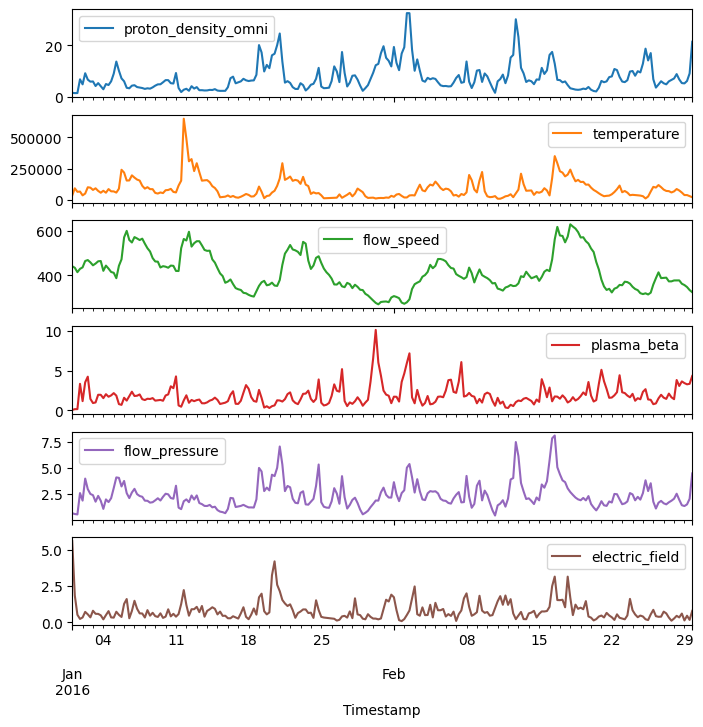

In [130]:
df_omni.plot(subplots=True, figsize=(8,8))
plt.show()

### Reading in Wind data

#### Electron data
6-hour averages, first processed and saved to `.pkl` file in `process_data_wind_electrons.py`

In [131]:
df_electrons = pd.read_pickle('data/processed/wi_elm2_3dp_6hr.pkl')
df_electrons.columns = df_electrons.columns.str.lower()
df_electrons = df_electrons.rename(
    columns={
        'density':'electron_density_wind', # n/cc
        'avgtemp':'electron_temperature', # eV
        'velocity_0':'electron_velocity_0', # km/s
        'velocity_1':'electron_velocity_1',
        'velocity_2':'electron_velocity_2'})
df_electrons.describe()

,electron_density_wind,electron_temperature,electron_velocity_0,electron_velocity_1,electron_velocity_2
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,3.505369,14.045693,-528.744507,58.350426,-28.723679
std,1.667939,2.611206,56.718494,20.462563,20.049084
min,0.636881,9.328401,-650.537354,-1.827031,-92.456978
25%,2.539840,11.813660,-575.421310,48.042364,-34.712104
50%,3.114274,14.666605,-509.333969,59.122490,-27.079688
75%,3.888707,15.567647,-485.213432,68.278288,-21.535178
max,9.831376,23.853952,-404.157928,124.091782,17.562920


In [132]:
# Checking for missing values
df_electrons.isna().any()

electron_density_wind    False
electron_temperature     False
electron_velocity_0      False
electron_velocity_1      False
electron_velocity_2      False
dtype: bool

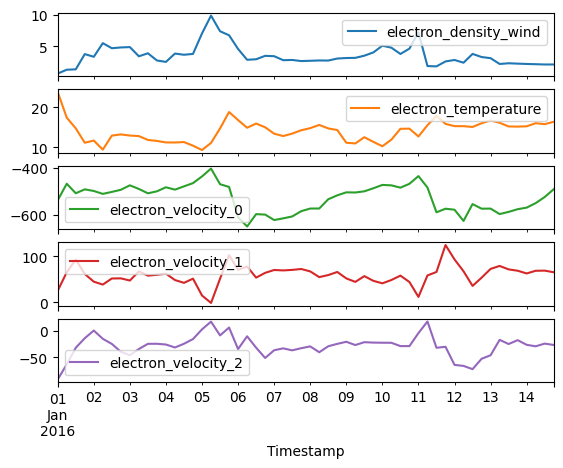

In [133]:
df_electrons.plot(subplots=True)
plt.show()

#### Proton data

6-hour averages, first processed and saved to `.pkl` file in `process_data_omni.py`

In [134]:
df_protons = pd.read_pickle("data/processed/wi_plsp_3dp_6hr.pkl")
df_protons.columns = df_protons.columns.str.lower()
df_protons = df_protons.rename(
    columns={
        'mom.p.density':'proton_density_wind',
        'mom.p.avgtemp':'proton_temperature',
        'mom.p.velocity_0':'proton_velocity_0',
        'mom.p.velocity_1':'proton_velocity_1',
        'mom.p.velocity_2':'proton_velocity_2'})
df_protons.describe()

,proton_density_wind,proton_temperature,proton_velocity_0,proton_velocity_1,proton_velocity_2
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,4.299490,19.907368,-495.726440,17.454563,-6.304993
std,2.192486,10.241973,57.281078,16.057425,18.129818
min,1.316161,9.789320,-624.581421,-25.493786,-46.306183
25%,2.748313,12.984211,-546.765137,11.398095,-16.259240
50%,4.050215,15.395069,-477.466751,17.909070,-7.285550
75%,5.093310,24.222755,-451.767342,26.155148,2.577097
max,13.190617,53.153130,-398.106445,65.315598,35.991684


In [135]:
# Checking for missing values
df_protons.isna().any()

proton_density_wind    False
proton_temperature     False
proton_velocity_0      False
proton_velocity_1      False
proton_velocity_2      False
dtype: bool

Now that we have the proton density from Wind (assuming this is better to use than that from OMNI for the same time period), we can calculate the ion inertial length $d_i$. This can be thought of as he thickness of the current sheets that form in turbulent plasma, and will be used as one method of calculating the Reynolds number of the solar wind. It may also help us to identify the slope of the dissipation range, required for Chuychai's method of obtaining refined estimates of the Taylor scale.

$$d_i=c/\omega_{i}=V_A/\Omega_I=2.28\times10^2\times\frac{\sqrt{\mu/n_i}}{Z} \text{km}$$
- $c$ is the speed of light
- $\omega_{i}$ is the (local) ion plasma frequency
- $V_A$ is the Alfven speed
- $\Omega_i$ is the ion gyrofrequency
- $\mu$ is the ratio of the ion mass to proton mass
- $n_i$ is the ion number density
- $Z$ is the charge state

For protons, this reduces to 

$$d_i=2.28\times10^2\times\sqrt{1/n_i} \text{km}$$

This should be in the range of 100-200km @ 1AU


In [176]:
df_protons["ion_inertial_length"] = ((df_protons.proton_density_wind)**-0.5)*2.28e2
df_protons[["ion_inertial_length"]].describe()

,ion_inertial_length
count,52.000000
mean,119.387543
std,28.322565
min,62.777252
25%,101.026512
50%,113.291420
75%,137.533691
max,198.737747


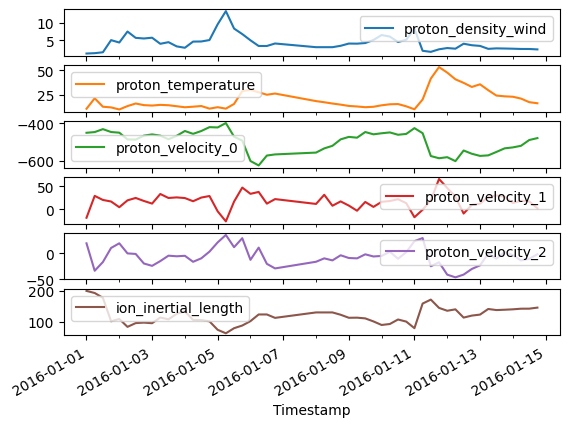

In [137]:
df_protons.plot(subplots=True)
plt.show()

#### Magnetic field data

##### 11Hz data
(Resampled to dt = 0.091s)

In [138]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_hr.pkl")
large_wind_df_hr.describe()

,BF1,BGSE_0,BGSE_1,BGSE_2
count,1.329231e+07,1.329231e+07,1.329231e+07,1.329231e+07
mean,6.310033e+00,-3.598496e-01,2.001786e-01,1.030636e-01
std,2.262501e+00,4.019368e+00,4.119052e+00,3.403764e+00
min,5.505295e-02,-1.272661e+01,-1.121677e+01,-1.375742e+01
25%,4.814053e+00,-3.759213e+00,-2.863658e+00,-1.780456e+00
50%,5.673542e+00,-8.764111e-01,8.125620e-01,2.148625e-01
75%,7.199578e+00,3.065059e+00,3.200431e+00,2.024960e+00
max,1.715050e+01,9.878662e+00,1.578569e+01,1.310275e+01


In [139]:
# Checking for missing values
large_wind_df_hr.isna().any()

BF1       False
BGSE_0    False
BGSE_1    False
BGSE_2    False
dtype: bool

Adding magnetic field fluctuations

$$\frac{db}{B_0}=\frac{\sqrt{(B_x-\langle B_x\rangle)^2+(B_y-\langle B_y\rangle)^2+(B_z-\langle B_z\rangle)^2}}{B_0}$$

In [180]:
large_wind_df_hr["dbx"] = large_wind_df_hr["BGSE_0"] - large_wind_df_hr["BGSE_0"].mean()
large_wind_df_hr["dby"] = large_wind_df_hr["BGSE_1"] - large_wind_df_hr["BGSE_1"].mean()
large_wind_df_hr["dbz"] = large_wind_df_hr["BGSE_2"] - large_wind_df_hr["BGSE_2"].mean()
large_wind_df_hr["db"] = np.sqrt(large_wind_df_hr["dbx"]**2+large_wind_df_hr["dby"]**2+large_wind_df_hr["dbz"]**2)
large_wind_df_hr["db/B0"] = large_wind_df_hr["db"]/large_wind_df_hr["BF1"]

In [183]:
large_wind_df_hr[["db/B0"]].describe().round(2)

,db/B0
count,13292307.00
mean,0.99
std,0.06
min,0.07
25%,0.94
50%,0.98
75%,1.04
max,7.28


Taking the mean for each six-hour interval to add as a column to the final dataframe

In [185]:
turb_fluc_hr = large_wind_df_hr[["db/B0"]].resample("6H").mean()
turb_fluc_hr.head()

,db/B0
Timestamp,
2016-01-01 00:00:00,1.019061
2016-01-01 06:00:00,1.028141
2016-01-01 12:00:00,1.044009
2016-01-01 18:00:00,1.058542
2016-01-02 00:00:00,1.040556


In [142]:
# Working with a single 6-hour interval
length_arr_hr = int(6*60*60*(1/0.091))

wind_df_hr = large_wind_df_hr[:length_arr_hr]
wind_df_hr.shape

(237362, 9)

In [143]:
wind_df_hr

,BF1,BGSE_0,BGSE_1,BGSE_2,dbx,dby,dbz,db,db/B0
Timestamp,,,,,,,,,
2016-01-01 00:00:00.000,14.943860,5.879855,-1.579370,-13.647411,6.239704,-1.779548,-13.750475,15.204482,1.017440
2016-01-01 00:00:00.091,14.939990,5.890072,-1.591034,-13.637410,6.249922,-1.791212,-13.740474,15.201006,1.017471
2016-01-01 00:00:00.182,14.915795,5.862018,-1.610130,-13.620763,6.221867,-1.810309,-13.723826,15.176702,1.017492
2016-01-01 00:00:00.273,14.936459,5.875757,-1.632746,-13.634788,6.235606,-1.832924,-13.737851,15.197729,1.017492
2016-01-01 00:00:00.364,14.943197,5.881089,-1.634825,-13.639622,6.240939,-1.835004,-13.742685,15.204537,1.017489
...,...,...,...,...,...,...,...,...,...
2016-01-01 05:59:59.487,10.363774,4.225235,-9.426723,-0.831916,4.585085,-9.626902,-0.934979,10.703944,1.032823
2016-01-01 05:59:59.578,10.352386,4.167100,-9.432401,-0.914859,4.526950,-9.632579,-1.017923,10.691867,1.032793
2016-01-01 05:59:59.669,10.335396,4.159393,-9.410312,-0.982792,4.519242,-9.610490,-1.085855,10.675400,1.032897


Note imperfect interval boundaries due to janky cadence

In [144]:
# Takes ~ 3min
#wind_df_hr.plot(subplots=True)

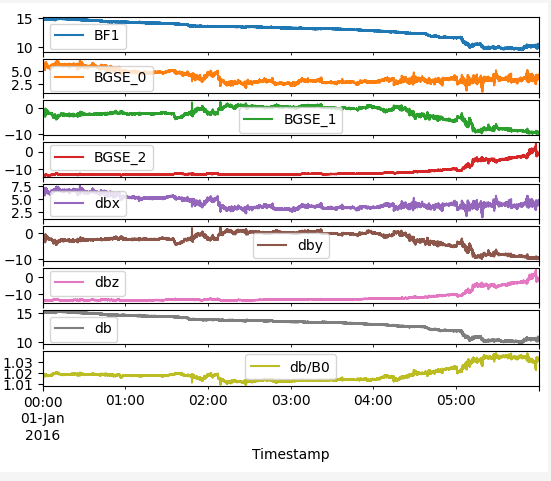

##### 0.2Hz data

In [145]:
large_wind_df_lr = pd.read_pickle("data/processed/wi_h2_mfi_lr.pkl")
large_wind_df_lr.describe()

,BF1,BGSE_0,BGSE_1,BGSE_2
count,241920.000000,241920.000000,241920.000000,241920.000000
mean,6.310163,-0.359540,0.201441,0.103327
std,2.261223,4.015538,4.113845,3.395684
min,0.122947,-12.501729,-10.827972,-13.657980
25%,4.815931,-3.755956,-2.854166,-1.775184
50%,5.673298,-0.874636,0.816870,0.214865
75%,7.199165,3.060749,3.194607,2.017385
max,16.993708,9.423657,15.568968,12.924106


In [146]:
# Working with a single 6-hour interval
length_arr_lr = int(6*60*60*0.2)

wind_df_lr = large_wind_df_lr[:length_arr_lr]
wind_df_lr.shape

(4320, 4)

In [186]:
wind_df_lr

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2016-01-01 00:00:00,14.960377,5.892269,-1.597420,-13.657980
2016-01-01 00:00:05,14.943271,5.893493,-1.596435,-13.638803
2016-01-01 00:00:10,14.942538,5.841498,-1.643213,-13.654799
2016-01-01 00:00:15,14.943983,5.867721,-1.650481,-13.644319
2016-01-01 00:00:20,14.927631,5.929097,-1.638702,-13.600977
...,...,...,...,...
2016-01-01 05:59:35,10.407626,3.964926,-9.584371,-0.855345
2016-01-01 05:59:40,10.524644,3.976334,-9.700571,-0.918856
2016-01-01 05:59:45,10.293777,3.995200,-9.434019,-0.994201


array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

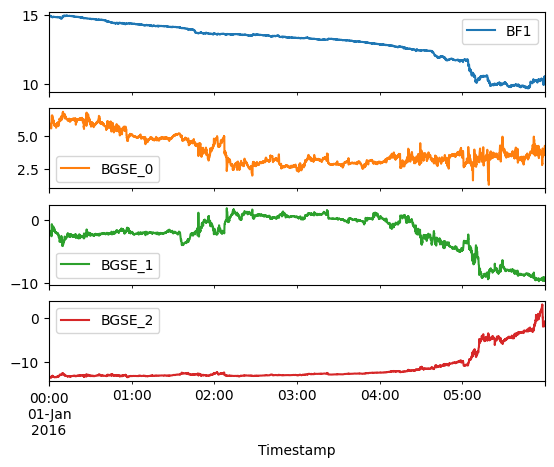

In [147]:
wind_df_lr.plot(subplots=True)

In order to fully implement Chuychai's method, we need the spectral index (slope) of the power law in the dissipation range. Here we compute a smoothed 3D periodogram for a single high-res interval, then perform a least squares fit of a power law to the inertial and kinetic ranges to determine their slopes and the spectral break.

In [148]:
# Calculate 3D power spectrum
import scipy.signal as signal

def SmoothySpec(a,nums=None):
   """Smooth a curve using a moving average smoothing"""
   b=a.copy()
   if nums is None: nums=2*len(b)//3
   for i in range(nums):
      b[i+1:-1] = 0.25*b[i:-2]+0.5*b[i+1:-1]+0.25*b[i+2:]
   return b

def fitpowerlaw(ax,ay,xi,xf):
   idxi=np.argmin(abs(ax-xi))
   idxf=np.argmin(abs(ax-xf))
   xx=np.linspace(xi,xf,100)
   z=np.polyfit(np.log(ax[idxi:idxf]),np.log(ay[idxi:idxf]),1);
   p=np.poly1d(z);
   pwrl=np.exp(p(np.log(xx)))
   return z,xx,pwrl

def compute_spectral_stats(np_array, dt, f_min_inertial, f_max_inertial, f_min_kinetic, f_max_kinetic, di = None, velocity = None,show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    ### Args:

    - np_array: Array of shape (1,n) or (3,n)
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds
    - di: (Optional, only used for plotting) Ion inertial length in km
    - velocity: (Optional, only used for plotting) Solar wind velocity in km/s
    - corr_scale: (Optional, only used for plotting) Correlation scale (seconds)
    - taylor_scale: (Optional, only used for plotting) Taylor scale (seconds)
    ### Returns:

    - z_i: Slope in the inertial range
    - z_k: Slope in the kinetic range
    - spectral_break: Frequency of the spectral break between the two ranges

    """
    x_freq = 1/dt

    f_periodogram, power_periodogram_0 = signal.periodogram(np_array[0], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_0 = (x_freq/2)*power_periodogram_0

    f_periodogram, power_periodogram_1 = signal.periodogram(np_array[1], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_1 = (x_freq/2)*power_periodogram_1

    f_periodogram, power_periodogram_2 = signal.periodogram(np_array[2], fs = x_freq, window="boxcar", scaling="density")
    power_periodogram_2 = (x_freq/2)*power_periodogram_2

    power_periodogram = (power_periodogram_0 + power_periodogram_1 + power_periodogram_2)/3

    p_smooth = SmoothySpec(power_periodogram) # Slowest part of this function - takes ~ 10 seconds

    zk, xk, pk = fitpowerlaw(f_periodogram, p_smooth, f_min_kinetic, f_max_kinetic) # Kinetic range
    zi, xi, pi = fitpowerlaw(f_periodogram, p_smooth, f_min_inertial, f_max_inertial) # Inertial range

    powerlaw_intersection = np.roots(zk-zi)
    spectral_break = np.exp(powerlaw_intersection)

    if show == True:
        plt.semilogy(f_periodogram, power_periodogram, label = "Raw periodogram")
        plt.semilogy(f_periodogram, p_smooth, label = "Smoothed periodogram", color = "cyan")
        plt.semilogy(xi, pi, c = "red", label = "Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(zi[0]))
        plt.semilogy(xk, pk, c = "yellow", label = "Kinetic range power-law fit: $\\alpha_k$ = {0:.2f}".format(zk[0]))
        plt.semilogx()
        plt.axvline(np.exp(np.roots(zk-zi)), color = "black", label = "Spectral break: $f_d={0:.2f}$".format(spectral_break[0]))

        # If we can convert di into a frequency using v_SW, we could add this to the plot
        if di is not None and velocity is not None:
            f_di = velocity/(2*np.pi*di)
            plt.axvline(f_di, color = "green", label = "Proton inertial frequency: $f_{di}=$" + "{0:.2f}".format(f_di))

        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD')
        plt.legend()
        plt.title("Power spectrum")
        plt.grid()
        plt.show()

    return zi[0], zk[0], spectral_break[0]

**Maths for calculating breakpoint:**

Each power-law fit is given by the following equation:

$$y =x^me^c$$

This is because if we take the log of both sides, we get the formula for a straight line on a log-log plot:

$$\log(y) = m\log(x)+c$$

We want to find the x-value for which the two power-laws are equal. We can do this by subtracting one from the other and finding the value of $\log(x)$ where this subtraction = 0, i.e., the root of the equation.

$$m_1\log(x)+c_1-m_2\log(x)-c_2=0$$

Finally, we take the exponential of this root to get the x-value of the spectral break

$$x = e^{\log(x)}$$

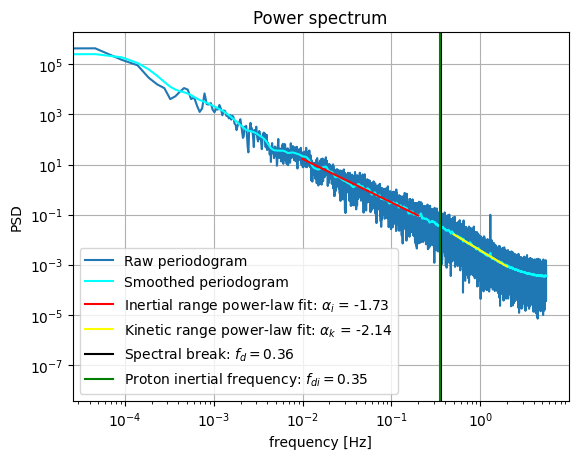

(-1.7345063155894773, -2.1394108557912146, 0.3605737910311339)

In [149]:
compute_spectral_stats(
    np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), 
    dt = 0.091, 
    f_min_inertial = 0.01, f_max_inertial = 0.2, 
    f_min_kinetic = 0.5, f_max_kinetic = 2,
    di = df_protons.loc["2016-01-01 00:00:00", "ion_inertial_length"],
    velocity = df_omni.loc["2016-01-01 00:00:00", "flow_speed"],
    show=True)

- $\alpha_{i}=-1.64$
- $\alpha_{k}=-2.58$
- $f_d=0.27$ Hz (dissipation scale)
- $\tau_d=1/f_d=1/0.27=3.7$ s

Chuychai et al. recommend that the resolution of the data be at least as good as $\Delta t <0.4\tau_d$. We later find the mean value of $\tau_d$ to be $1/0.25=4$. Using this value, we see our resolution is sufficient:

- $1/11 = 0.091$
- $0.4\times4=1.6$
- $0.091 < 1.6$

We should also justify the frequency bounds of the inertial and kinetic ranges we have specified.
*The kinetic range is usually above the spacecraft frame frequency corresponding to the proton inertial length, $f_{pi}=v_{SW}/(2\pi\lambda_{pi}$)* (from Pitna et al. (2021)).



### ACF function

This is what we use to calculate the correlation scale and Taylor scale. Note that Chuychai et al. did not calculate the ACF directly from the data; they calculated it from $D_2$. Here, we will calculate it directly from the data.

Following function is based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. Automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows (before normalisation)

$$R(\tau)=\frac{1}{3}\times(R_x(\tau)+R_y(\tau)+R_z(\tau))$$

*Should `tsa.acf()` be set to `fft=False`? Default is True. Check for differences in speed.*

In [150]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.

    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """
    if np_array.shape[0] == 3:
        acf = \
            sm.tsa.acf(np_array[0], fft=True, nlags=nlags) + \
            sm.tsa.acf(np_array[1], fft=True, nlags=nlags) + \
            sm.tsa.acf(np_array[2], fft=True, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=True, nlags=nlags)

    else:
        raise ValueError(
            "Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt

    # Optional plotting
    if show == True:

        fig, ax = plt.subplots(constrained_layout=True)

        ax.plot(time_lags, acf)
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')

        plt.show()

    return time_lags, acf


The following low-res ACF will be used for calculating the outer scale.

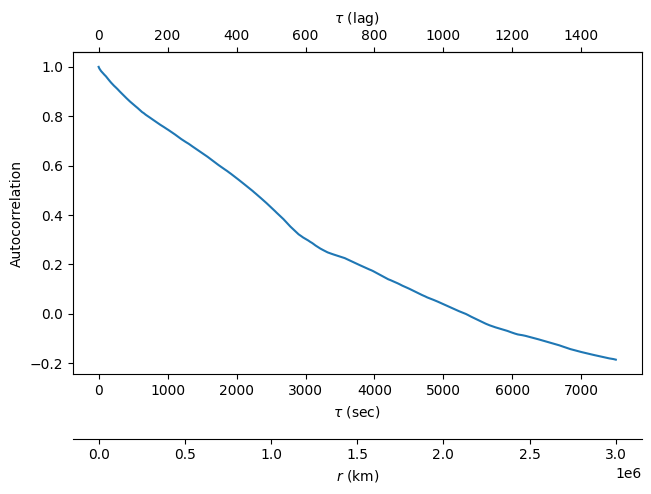

In [151]:
time_lags_lr, r_vec_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), nlags=1500, dt = 5, show = True)

The following high-res ACF will be used for calculating the Taylor scale.

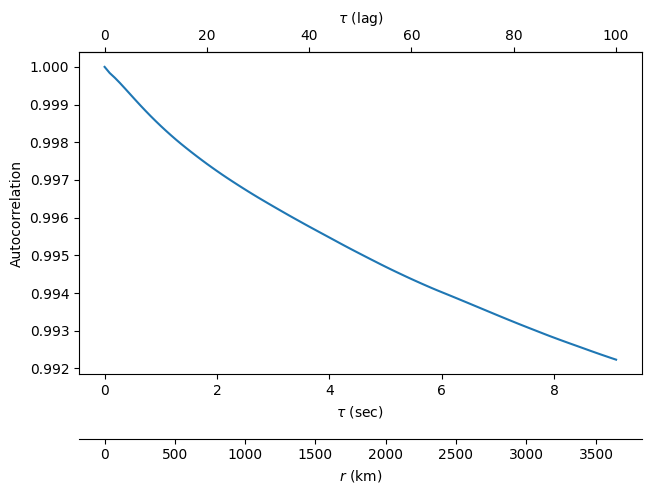

In [187]:
time_lags_hr, r_vec_hr = compute_nd_acf(np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), nlags=100, dt = 0.091, show = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Methods for calculating:
- 1/e trick
- Exponential fit
- Integral

Smith et al. (2001) used the 1/e trick method and the integral method. In Appendix B of this paper, they show how the estimates by either method increase depending on the lag up to which you calculate the ACF.

Firstly, using Kevin's function (just with plotting functionality added) for computing outer scale using $1/e$ trick:

**If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.**

Kevin referred to the value calculated from this method in his analysis as `estimate` and `Correlation_timescale_est`.

In [153]:
# Already in utils
def compute_outer_scale_exp_trick(autocorrelation_x: np.ndarray, autocorrelation_y: np.ndarray, show = False):
    """
    computes the correlation scale through the "1/e" estimation method.
    autocorrelation_x assumed already in time scale
    """
    for i, j in zip(autocorrelation_y, autocorrelation_x):
        if i <= np.exp(-1):
            # print(i, j)
            idx_2 = np.where(autocorrelation_x == j)[0]
            idx_1 = idx_2 - 1
            x2 = autocorrelation_x[idx_2]
            x1 = autocorrelation_x[idx_1]
            y1 = autocorrelation_y[idx_1]
            y2 = autocorrelation_y[idx_2]
            x_opt = x1 + ((y1 - np.exp(-1))/(y1-y2))*(x2-x1)
            # print(autocorrelation_x[idx_1], autocorrelation_y[idx_1])
            # print(autocorrelation_x[idx_2], autocorrelation_y[idx_2])
            # print('e:', np.exp(-1))
            # print(x_opt)

            try:

                # Optional plotting
                if show == True:

                    dt = autocorrelation_x[1]-autocorrelation_x[0]

                    fig, ax = plt.subplots(constrained_layout=True)
                    ax.plot(autocorrelation_x, autocorrelation_y)
                    ax.set_xlabel('$\\tau$ (sec)')
                    ax.set_ylabel('Autocorrelation')

                    # For plotting secondary axes
                    def sec2lag(x):
                        return x / dt

                    def lag2sec(x):
                        return x * dt

                    secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
                    secax_x.set_xlabel('$\\tau$ (lag)')

                    def sec2km(x):
                        return x * 400

                    def km2sec(x):
                        return x / 400

                    # use of a float for the position:
                    secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
                    secax_x2.set_xlabel('$r$ (km)')

                    plt.axhline(np.exp(-1), color = 'black')
                    plt.axvline(x_opt[0], color = 'black')
                    plt.show()

                return round(x_opt[0], 3)


            except Exception:
                return 0

    # none found
    return -1

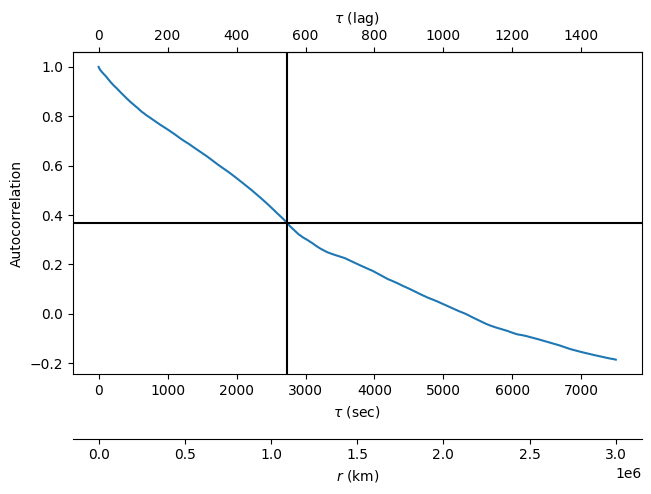

2732.171

In [154]:
compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, show = True)

Secondly, adapting Kevin's function for computing outer scale using exponential fit, from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$

Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

"The extent of the autocorrelation to fit on was determined to be 1000 seconds worth of lag, through some trial and error and inspection of plotted results" (de Lange, 2021). **We could choose this amount by referring to the value given by the 1/e method.** 

In [155]:
from utils import exp_fit

def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]


    # Optional plotting
    if show == True:

        fig, ax = plt.subplots()
        ax.plot(time_lags, acf, label = "Autocorrelation")
        ax.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')
        ax.legend()
        plt.show()
    
    return lambda_c


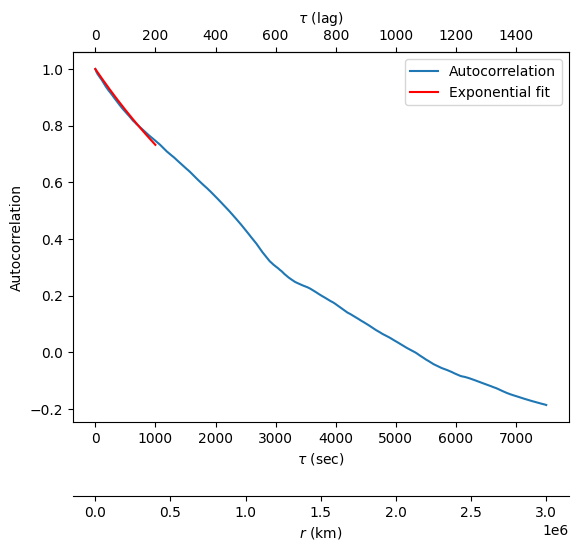

3206.474021773252

In [156]:
compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = 1000, show = True)

Finally, creating a function for computing outer scale as integral of the ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970). 

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [157]:
def compute_outer_scale_integral(time_lags, acf, show=False):

    dt = time_lags[1]-time_lags[0]
    idx = np.argmin(np.abs(acf))
    int = np.sum(acf[:idx])*dt

    # Optional plotting
    if show == True:
        fig, ax = plt.subplots()
        #ax.set_ylim(-.2, 1.2)
        ax.plot(time_lags, acf, label="Autocorrelation")
        ax.fill_between(time_lags, 0, acf, where=acf > 0)
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')

        plt.show()

    return int


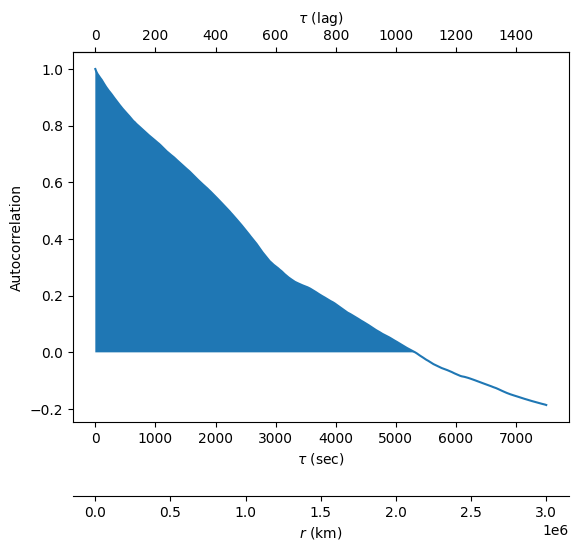

2276.8090899069066

In [158]:
compute_outer_scale_integral(time_lags_lr, r_vec_lr, show = True)

See Figure 9 of Isaacs et al. (2015), accompanying discussion on pg10 of paper.


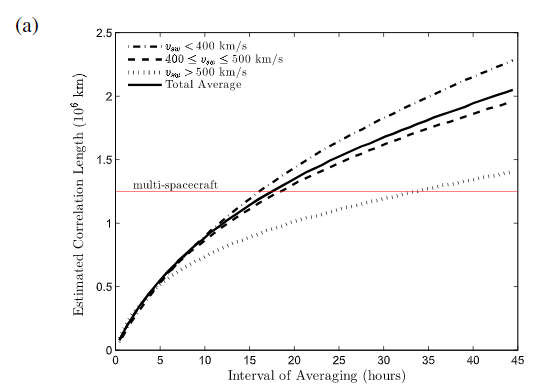

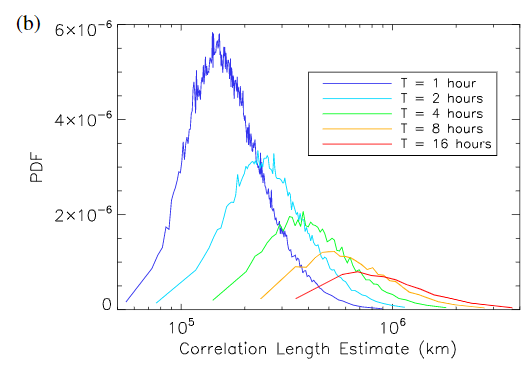

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This code is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [159]:
from utils import para_fit

def compute_taylor_scale(time_lags, acf, tau_fit, show=False, show_intercept = False):
    """Compute the Taylor microscale

    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_fit: number of lags to fit the parabola over
    """

    # If using seconds_fit as the fitting argument instead:

    dt = time_lags[1]-time_lags[0]
    # tau_fit = int(seconds_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:tau_fit],
        acf[:tau_fit],
        p0=10) # Initial guess for the parameters
    lambda_t = (-1*t_opt[0])**-.5

    extended_parabola_x = np.arange(0, 1.2*lambda_t, 0.1)
    extended_parabola_y = para_fit(extended_parabola_x, *t_opt)

    # Optional plotting
    if show == True:

        mpl_fig = plt.figure()
        fig, ax = plt.subplots()
        ax.scatter(time_lags, acf, label="Autocorrelation", s = 0.5)
        ax.plot(
            extended_parabola_x,
            extended_parabola_y,
            '-y',
            label="Parabolic fit")
        #plt.axhline(0, color = 'black')
        ax.axvline(0, color='green')
        ax.axvline(tau_fit*(time_lags[1]-time_lags[0]), color='green')

        ax.set_xlim(-0.2, tau_fit*dt*2)
        ax.set_ylim(0.99, 1.001)

        if show_intercept == True:
            ax.set_ylim(0, 1.05)
            ax.set_xlim(-2, lambda_t + 5)

        ax.set_xlabel('$\\tau$ (sec)')
        ax.set_ylabel('Autocorrelation')

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, lag2sec))
        secax_x.set_xlabel('$\\tau$ (lag)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r$ (km)')
        
        ax.legend()
        plt.show()

    return lambda_t


<Figure size 640x480 with 0 Axes>

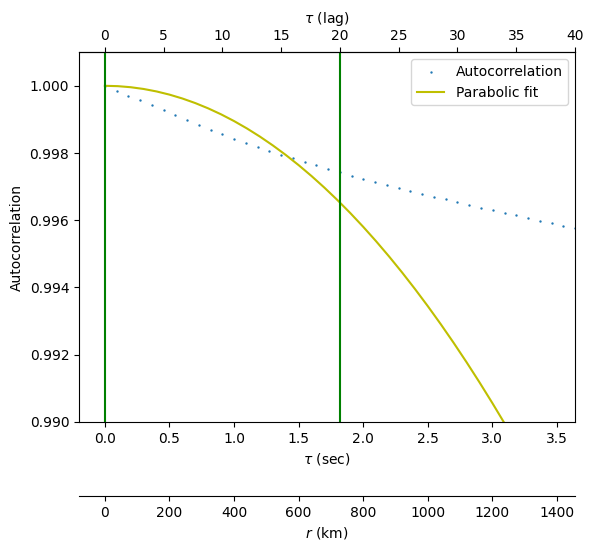

30.873422930313414

In [160]:
compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=20, show = True, show_intercept=False)

#### Chuychai (Richardson) extrapolation method

Calculate Taylor scale from parabolic fit for a range of values of $\tau_{fit}$, up to $\tau_{max}$. Plot these values as a function of $\tau_{fit}$, then draw a straight line through the points back to `tau_{fit}`=0. For the ACE data, Chuychai et al. used the range $4<\tau_{fit}<25$. **This corresponds to between 1.33 and 8.33 seconds**.

For PSP data, Phillips et al. (2022) used the range $3<\tau_{fit}<20$. **This corresponds to between 0.01 and 0.07 seconds** (In this study, the authors also reported an error for each Taylor scale calculation as the standard deviation given by the fit. )

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{fit}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

How do we find the upper value, $\tau_{max}$? This is investigated in Fig. 5 of Chuychai. Weygand et al. (2007) show an example of reaching a stable estimate as $\tau_{max} increases, but Chuychai shows that this is dependent on the spectral index.

**Tulasi recommended that we think in terms of the physical system, i.e., in terms of seconds rather than lags.** Given this, he suggested
- $\tau_{min}> 1s$ 
- $5s<\tau_{max}<10s$

He also suggested once deciding on a setting, running the codes on the data and then looking at the plots below for extreme values of $t_{est}$ ("case studies"), seeing if anything needs to be changed. We could also incorporate some kind of consistency check into the function that compares $t_{est}$ with $t_{min}$ to suggest an appropriate range to fit over.

In [161]:
def compute_taylor_chuychai(time_lags, acf, tau_min, tau_max, q=None, show=False):
    """Compute a refined estimate of the Taylor microscale using a linear extrapolation method from Chuychai et al. (2014).

    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_min: Minimum value for the upper lag to fit the parabola over. This should not be too small, because the data has finite time resolution and there may be limited data available at the shortest time lags. (You will see divergent behaviour if this happens.)
    - tau_max: Maximum value for the upper lag to fit the parabola over
    - q: Slope of the dissipation range
    """

    dt = time_lags[1]-time_lags[0]

    tau_fit = np.arange(tau_min, tau_max+1)
    tau_ts = np.array([])

    for i in tau_fit:
        lambda_t = compute_taylor_scale(time_lags, acf, tau_fit=i, show=False)
        tau_ts = np.append(tau_ts, lambda_t)

    # Performing linear extrapolation back to tau_fit = 0
    z, cov = np.polyfit(x=tau_fit, y=tau_ts, deg=1, cov=True)
    f = np.poly1d(z)

    ts_est = z[1] # Extracting y-intercept
    
    # Getting error bars
    #ts_est_std = np.sqrt(cov[1,1])
    #ts_est_lower = ts_est - ts_est_std

    # Getting extrapolation line for plotting
    other_x = np.arange(0, tau_max+1)
    other_y = f(other_x)


    # Applying correction factor q from Chuychai et al. (2014)
    if q is not None:
        q_abs = np.abs(q)
        if q_abs < 2:
            r = -0.64*(1/q_abs)+0.72
        elif q_abs >= 2 and q_abs < 4.5:
            r = -2.61*(1/q_abs)+1.7
        elif q_abs >= 4.5:
            r = -0.16*(1/q_abs)+1.16

    else:
        r = 1

    ts_est_final = r*ts_est 

    # Optional plotting
    if show == True:
        fig, ax = plt.subplots()
        ax.plot(tau_fit*dt, tau_ts, color="blue",
                 label="Range over which $\\tau_{TS}$ was calculated")
        ax.plot(other_x*dt, other_y, color="black",
                 label="Linear extrapolation to $\\tau_{fit}$=0", ls='--')
        if q is not None:
            ax.plot(0, ts_est_final, "go", label = "Final estimate with correction ratio applied (q={0:.2f})".format(q))
        ax.set_xlabel("$\\tau_{fit}$ (sec)")
        ax.set_ylabel("$\\tau_{fit}^{est}$ (sec)")

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis('top', functions=(sec2lag, sec2lag))
        secax_x.set_xlabel('$\\tau_{fit}$ (lags)')

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel('$r_{fit}$ (km)')

        plt.show()

    return ts_est_final
    #, z, cov


We can compare the following to Fig. 4 in Chuychai, and less directly to Figs. 5 and 7 in Weygand et al. (2007)

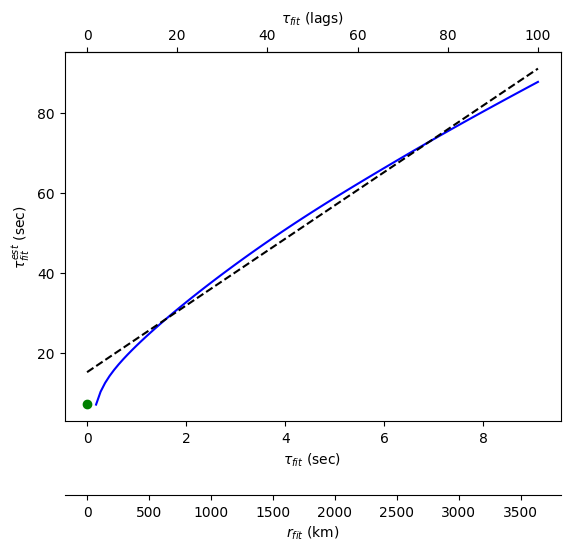

7.3111550765237086

In [162]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=2, tau_max=100, q = -2.14, show = True)

The estimates will converge as a function of $\tau_fit$ if the r/ship remains linear. Therefore, the min-max values should cover a range that looks linear, and is ideally in range with other estimates. 

Given the more linear relationship in the second plot, I will go with `tau_min=20` and `tau_max=50` for now.

As noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resolution and there may be limited data available at the shortest time lags".

This paper also notes that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess". The equation for this final estimate is given in Eq. 10 of the paper.

## Constructing the final dataframe

In [52]:
# Splitting entire dataframe into a list of 6-hour intervals

length_arr_lr = int(6*60*60*0.2)
length_arr_hr = int(6*60*60*(1/0.091))+1

n_intervals_lr = int(np.floor(len(large_wind_df_lr)/length_arr_lr))
wind_df_lr_list = np.split(large_wind_df_lr[:n_intervals_lr*length_arr_lr], n_intervals_lr)

n_intervals_hr = int(np.floor(len(large_wind_df_hr)/length_arr_hr))
wind_df_hr_list = np.split(large_wind_df_hr[:n_intervals_hr*length_arr_hr], n_intervals_hr)

Checking timestamp bounds of high-res interval, given 0.091s doesn't nicely go into 6 hours. Note this this effect will worsen with increasing data

In [54]:
wind_df_hr_list[0]

,BF1,BGSE_0,BGSE_1,BGSE_2,dbx,dby,dbz,db,db/B0
Timestamp,,,,,,,,,
2016-01-01 00:00:00.000,14.943860,5.879855,-1.579370,-13.647411,6.239704,-1.779548,-13.750475,15.204482,1.017440
2016-01-01 00:00:00.091,14.939990,5.890072,-1.591034,-13.637410,6.249922,-1.791212,-13.740474,15.201006,1.017471
2016-01-01 00:00:00.182,14.915795,5.862018,-1.610130,-13.620763,6.221867,-1.810309,-13.723826,15.176702,1.017492
2016-01-01 00:00:00.273,14.936459,5.875757,-1.632746,-13.634788,6.235606,-1.832924,-13.737851,15.197729,1.017492
2016-01-01 00:00:00.364,14.943197,5.881089,-1.634825,-13.639622,6.240939,-1.835004,-13.742685,15.204537,1.017489
...,...,...,...,...,...,...,...,...,...
2016-01-01 05:59:59.578,10.352386,4.167100,-9.432401,-0.914859,4.526950,-9.632579,-1.017923,10.691867,1.032793
2016-01-01 05:59:59.669,10.335396,4.159393,-9.410312,-0.982792,4.519242,-9.610490,-1.085855,10.675400,1.032897
2016-01-01 05:59:59.760,10.356019,4.168725,-9.420629,-1.058593,4.528575,-9.620807,-1.161656,10.696605,1.032888


In [55]:
wind_df_hr_list[-1]

,BF1,BGSE_0,BGSE_1,BGSE_2,dbx,dby,dbz,db,db/B0
Timestamp,,,,,,,,,
2016-01-14 12:00:01.886,4.422976,4.321471,-0.420586,0.843035,4.681320,-0.620764,0.739972,4.779923,1.080703
2016-01-14 12:00:01.977,4.416978,4.318186,-0.405461,0.835802,4.678036,-0.605639,0.732738,4.773649,1.080750
2016-01-14 12:00:02.068,4.419008,4.318532,-0.408569,0.843195,4.678382,-0.608748,0.740132,4.775524,1.080678
2016-01-14 12:00:02.159,4.412716,4.313283,-0.383220,0.849000,4.673132,-0.583399,0.745937,4.768117,1.080540
2016-01-14 12:00:02.250,4.389089,4.293013,-0.366251,0.836660,4.652863,-0.566430,0.733596,4.744274,1.080925
...,...,...,...,...,...,...,...,...,...
2016-01-14 18:00:01.464,4.174952,-3.162645,-0.611075,2.656029,-2.802795,-0.811253,2.552966,3.877038,0.928643
2016-01-14 18:00:01.555,4.165728,-3.134091,-0.608443,2.675923,-2.774241,-0.808622,2.572859,3.869094,0.928792
2016-01-14 18:00:01.646,4.183259,-3.167744,-0.639353,2.656367,-2.807894,-0.839532,2.553303,3.886958,0.929170


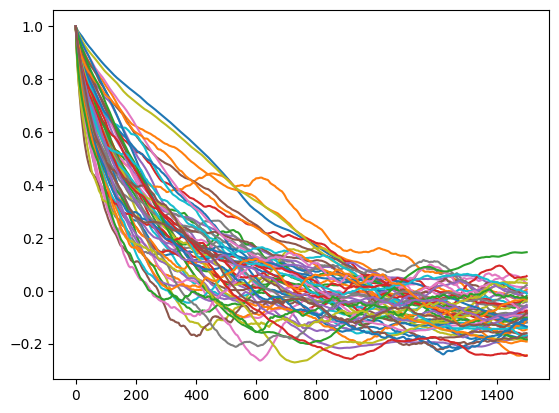

In [216]:
# Computing ACFs each low-res interval
dt_lr = 5

acf_lr_list = []

for i in np.arange(len(wind_df_lr_list)):

    time_lags_lr, acf = compute_nd_acf(
        np.array([wind_df_lr_list[i].BGSE_0, wind_df_lr_list[i].BGSE_1, wind_df_lr_list[i].BGSE_2]), 
        nlags = 1500, 
        dt=dt_lr)

    acf_lr_list.append(acf)

for acf in acf_lr_list:
    plt.plot(acf)

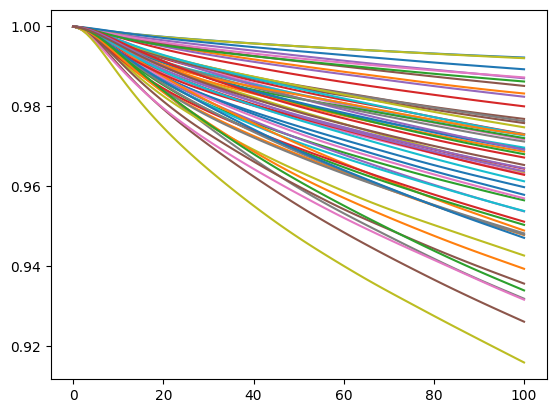

In [217]:
# Computing ACFs and spectral statistics for each high-res interval
# ~20s per interval due to spectrum smoothing algorithm

dt_hr = 0.091

acf_hr_list = []
inertial_slope_list = []
kinetic_slope_list = []
spectral_break_list = []

for i in np.arange(len(wind_df_hr_list)):

    time_lags_hr, acf = compute_nd_acf(
        np.array([
            wind_df_hr_list[i].BGSE_0,
            wind_df_hr_list[i].BGSE_1,
            wind_df_hr_list[i].BGSE_2
        ]),
        nlags=100,
        dt=dt_hr)

    acf_hr_list.append(acf)

    slope_i, slope_k, break_s = compute_spectral_stats(
        np.array([
            wind_df_hr_list[i].BGSE_0,
            wind_df_hr_list[i].BGSE_1, 
            wind_df_hr_list[i].BGSE_2
        ]),
        dt=dt_hr,
        f_min_inertial=0.01, f_max_inertial=0.2,
        f_min_kinetic=0.5, f_max_kinetic=2,
        show=False)

    inertial_slope_list.append(slope_i)
    kinetic_slope_list.append(slope_k)
    spectral_break_list.append(break_s)

for acf in acf_hr_list:
    plt.plot(acf)


In [232]:
# Computing scales for each interval

corr_scale_exp_fit_list = []
corr_scale_exp_trick_list = []
corr_scale_int_list = []

for acf in acf_lr_list:
    corr_scale_exp_fit = compute_outer_scale_exp_fit(
        time_lags_lr, acf, 1000, show=False)
    corr_scale_exp_fit_list.append(corr_scale_exp_fit)

    corr_scale_exp_trick = compute_outer_scale_exp_trick(time_lags_lr, acf)
    corr_scale_exp_trick_list.append(corr_scale_exp_trick)

    corr_scale_int = compute_outer_scale_integral(time_lags_lr, acf)
    corr_scale_int_list.append(corr_scale_int)

taylor_scale_kevin_list = []
taylor_scale_list = []

for i in range(len(acf_hr_list)):

    taylor_scale_kevin = compute_taylor_scale(
        time_lags_hr, 
        acf_hr_list[i], 
        tau_fit=20)
    taylor_scale_kevin_list.append(taylor_scale_kevin)

    taylor_scale = compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[i],
        tau_min=20,
        tau_max=50,
        q=kinetic_slope_list[i])

    taylor_scale_list.append(taylor_scale)


In [237]:
# Joining lists of scales and spectral_stats together into a dataframe

df_1 = pd.DataFrame({
    'corr_scale_exp_fit': corr_scale_exp_fit_list,
    'corr_scale_exp_trick': corr_scale_exp_trick_list,
    'corr_scale_int': corr_scale_int_list,
    'taylor_scale': taylor_scale_list,
    'taylor_scale_kevin': taylor_scale_kevin_list,
    'inertial_slope': inertial_slope_list,
    'kinetic_slope': kinetic_slope_list,
    'spectral_break': spectral_break_list
})


In [238]:
df_1.describe()

,corr_scale_exp_fit,corr_scale_exp_trick,corr_scale_int,taylor_scale,taylor_scale_kevin,inertial_slope,kinetic_slope,spectral_break
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,1026.564441,1140.502786,1014.808861,6.945826,17.080056,-1.654367,-2.829045,0.254384
std,557.672003,662.323202,510.132544,1.300078,4.805163,0.077319,0.343861,0.124382
min,381.362560,412.199000,35.276468,4.329907,10.161834,-1.861608,-3.571264,0.015294
25%,641.326339,668.748750,667.960841,6.022283,13.824242,-1.701389,-3.119954,0.173215
50%,916.907458,1019.898000,976.024028,6.855833,16.240617,-1.639541,-2.805467,0.239659
75%,1214.361649,1251.451500,1280.377722,7.366981,18.459510,-1.611786,-2.560567,0.325141
max,3206.474022,3455.159000,2276.809090,10.518714,30.873423,-1.476788,-2.050488,0.583731


Let's use the min and max values of the Taylor scale to evaluate the current settings of the estimation function

In [125]:
compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].min()][0]],
        tau_min=20,
        tau_max=50,
        q=kinetic_slope_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].min()][0]],
        show=True)

NameError: name 'acf_hr_list' is not defined

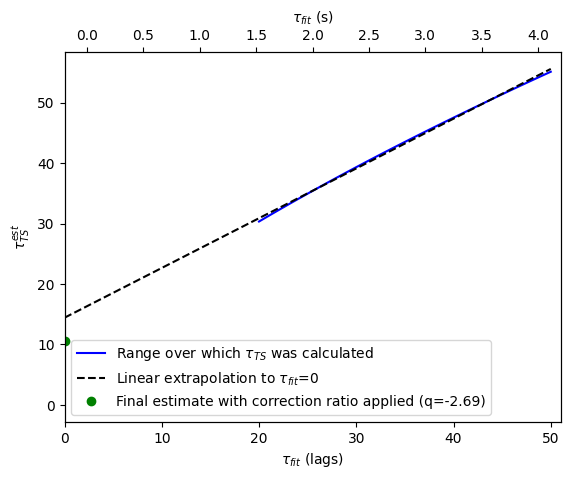

10.51871371041597

In [243]:
compute_taylor_chuychai(
        time_lags=time_lags_hr,
        acf=acf_hr_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].max()][0]],
        tau_min=20,
        tau_max=50,
        q=kinetic_slope_list[df_1.index[df_1["taylor_scale"]==df_1["taylor_scale"].max()][0]],
        show=True)

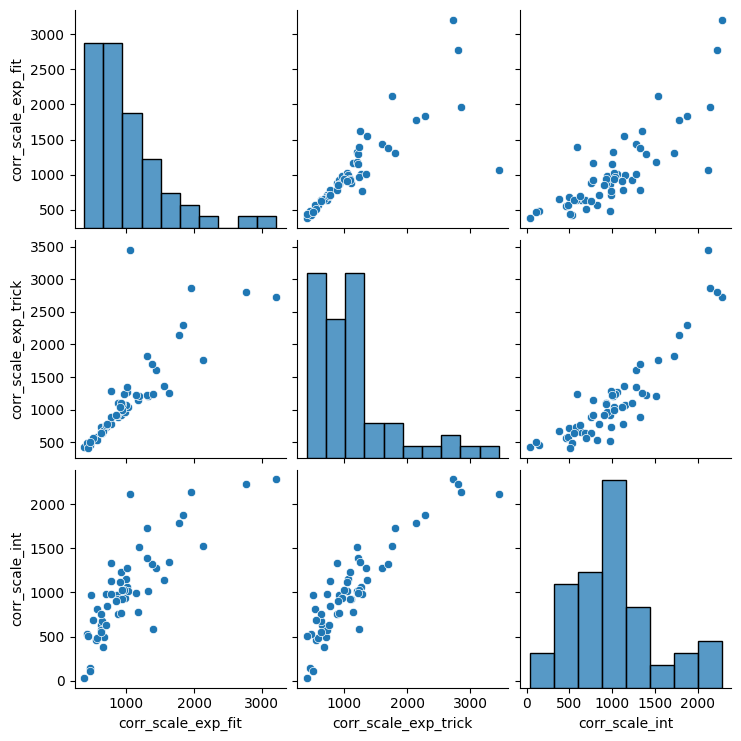

In [224]:
import seaborn as sns
sns.pairplot(df_1.iloc[:,:3])

In [246]:
# Joining other data together into a dataframe
df_2 = join_dataframes_on_timestamp(df_omni, df_electrons)
df_3 = join_dataframes_on_timestamp(df_2, df_protons)
df_4 = join_dataframes_on_timestamp(df_3, turb_fluc_hr)
df_5 = df_4.reset_index()

# Joining all data together into a dataframe
df_complete = df_5.join(df_1)
df_complete["taylor_scale_km"] = df_complete["taylor_scale"]*df_complete["flow_speed"]
df_complete

,Timestamp,proton_density_omni,temperature,flow_speed,plasma_beta,flow_pressure,electric_field,electron_density_wind,electron_temperature,electron_velocity_0,...,ion_inertial_length,db/B0,corr_scale_exp_fit,corr_scale_exp_trick,corr_scale_int,taylor_scale,taylor_scale_kevin,inertial_slope,kinetic_slope,spectral_break
0,2016-01-01 00:00:00,1.631000,36290.113281,440.639587,0.062431,0.637778,5.598134,0.636881,23.853952,-538.960938,...,198737.750000,1.019061,3206.474022,2732.171,2276.809090,7.281216,30.873423,-1.734506,-2.139411,0.360574
1,2016-01-01 06:00:00,1.501792,93113.062500,433.807373,0.155681,0.567444,1.835941,1.245301,17.447899,-468.791870,...,192002.421875,1.028141,1960.805520,2860.832,2136.718674,8.812373,23.360094,-1.641645,-2.580268,0.265556
2,2016-01-01 12:00:00,1.528361,65383.054688,413.849457,0.165069,0.526625,0.515656,1.306304,14.769058,-509.211945,...,176643.453125,1.044009,1008.390389,1265.346,1059.205536,5.089236,13.716390,-1.522379,-2.579637,0.176049
3,2016-01-01 18:00:00,6.850236,67298.859375,428.879181,3.348236,2.582833,0.227733,3.724676,11.154364,-492.649567,...,101302.304688,1.058542,1314.561250,1817.280,1725.360866,5.953130,17.752234,-1.659792,-2.473175,0.274728
4,2016-01-02 00:00:00,4.903958,37046.175781,435.607513,1.171292,1.856833,0.330308,3.297387,11.701526,-499.503906,...,108753.367188,1.040556,1554.806636,1367.971,1139.644852,9.248291,26.789185,-1.861608,-2.467411,0.567140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2016-02-28 18:00:00,5.390903,59273.695312,361.706543,3.654194,1.412542,0.598154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2016-02-29 00:00:00,5.269903,39359.515625,355.795288,3.440500,1.334111,0.123405,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2016-02-29 06:00:00,6.217403,39258.429688,346.831116,3.285653,1.493681,0.449150,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2016-02-29 12:00:00,9.139459,31012.351562,333.160583,3.350082,2.030241,0.161462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_complete

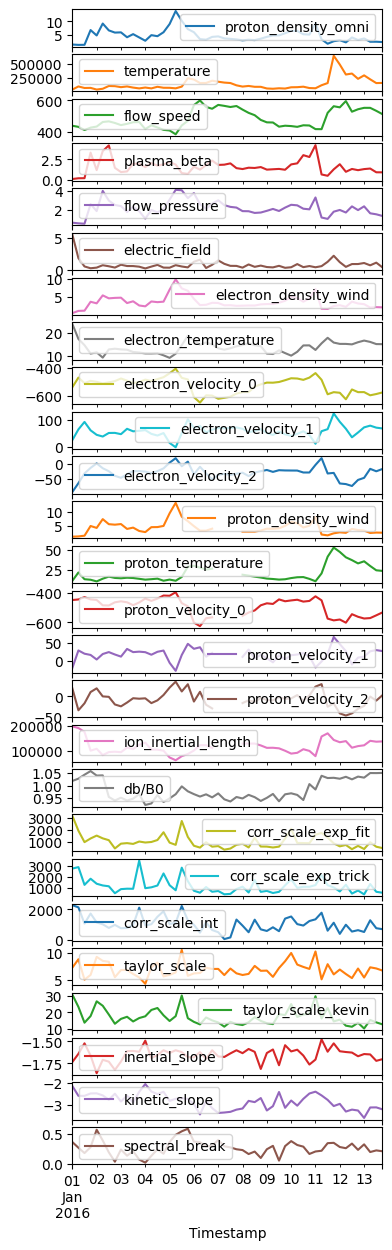

In [247]:
df_complete[df_complete["Timestamp"]<"2016-01-14"].plot(x = "Timestamp", subplots=True, figsize = (4, 15))
plt.show()

In [248]:
# Saving final dataframe
df_complete.to_csv("data/processed/df_complete.csv", index=False)

## Correlation plots

Using R script

![title](corr_matrix_Rplot.png)

![title](corr_ranked_Rplot.png)

![title](corr_ranked_taylor_Rplot.png)

Alt matrix, if we want smart ordering of variables

![title](corr_matrix_Rplot_old.png)